# Predicting Mandarin Song Popularity on Spotify

Import necessary packages 

In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression, ARDRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor,HistGradientBoostingRegressor,VotingRegressor,StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import base64
%matplotlib inline
sns.set_style('darkgrid')

## Step 1: Extract Data

#### The data we are using for this project comes directly from Spotify Web API.
#### I collected 3000 songs from year 2019 to 2021 with genre 'mando pop' as my training and testing set

Go to Spotify Web API Console to generate Bearer token

In [13]:
auth_token = "BQAbNoApNP48x6r_2G5qfAUFXzgEUIqpUxhYZx7WpETfpg77wXdzpxgkXYdQaIx9MqmnfKzGq3o0Om3O4F2JwBRORPJK-GwxbswcKg66Wf-7x5blrDWKy8CUmC-_eDZ4BjQTFZDV2Z9W1rsNbj1zlmK179d8SyuyXzkyAMFP96n3J2Nc"
headers = {
    'Authorization': 'Bearer {token}'.format(token=auth_token)
}

Create a list of song ids

In [14]:
iteration = 0
song_list = []
for i in range(20):
    result = requests.get(f'https://api.spotify.com/v1/search?q=year%3A2019%20genre%3Amandopop&type=track&limit=50&offset={iteration}', headers = headers)
    result2 = requests.get(f'https://api.spotify.com/v1/search?q=year%3A2020%20genre%3Amandopop&type=track&limit=50&offset={iteration}', headers = headers)
    result3 = requests.get(f'https://api.spotify.com/v1/search?q=year%3A2021%20genre%3Amandopop&type=track&limit=50&offset={iteration}', headers = headers)
    for track in result.json()['tracks']['items']:
        song_list.append(track['id'])
    for track in result2.json()['tracks']['items']:
        song_list.append(track['id'])
    for track in result3.json()['tracks']['items']:
        song_list.append(track['id'])
    iteration = iteration + 50

Function to divide song list into lists with specified length (spotify maximum offset is 50)

In [15]:
def divide_list(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [16]:
song_list_segment = list(divide_list(song_list, 50))

Extract songs' attributes

In [17]:
song_elements = []
for song_segment in song_list_segment:
    song_list = '%2C'.join(song_segment)
    track_response = requests.get(f'https://api.spotify.com/v1/tracks?ids={song_list}', headers = headers)
    tracks = track_response.json()
    audio_features_response = requests.get(f'https://api.spotify.com/v1/audio-features?ids={song_list}', headers = headers)
    audio_features = audio_features_response.json()
    for track, audio_feature in zip(tracks['tracks'],audio_features['audio_features']):
        # Get Song ID
        song_attribute_list = []
        track_uri = track["id"]
        song_attribute_list.append(track["id"])
        #Get Track name
        song_attribute_list.append(track["name"])
        #Get Main Artist URI
        song_attribute_list.append(track["artists"][0]["id"])
        #Get Artist Name
        song_attribute_list.append(track["artists"][0]["name"])
        #Get Album Name
        song_attribute_list.append(track["album"]["name"])
        #Get Track Popularity
        song_attribute_list.append(track["popularity"])
        #Get Songs Features
        song_attribute_list.append(audio_feature['danceability'])
        song_attribute_list.append(audio_feature['energy'])
        song_attribute_list.append(audio_feature['key'])
        song_attribute_list.append(audio_feature['loudness'])
        song_attribute_list.append(audio_feature['mode'])
        song_attribute_list.append(audio_feature['speechiness'])
        song_attribute_list.append(audio_feature['acousticness'])
        song_attribute_list.append(audio_feature['instrumentalness'])
        song_attribute_list.append(audio_feature['liveness'])
        song_attribute_list.append(audio_feature['valence'])
        song_attribute_list.append(audio_feature['tempo'])
        song_attribute_list.append(audio_feature['duration_ms'])
        song_attribute_list.append(audio_feature['time_signature'])
        song_elements.append(song_attribute_list)  

Convert list of attributes to dataframe

In [18]:
df = pd.DataFrame(song_elements, columns=['track_id','track_name','artist_id','artist_name','album','track_popularity','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature'])

## Step 2: Explore Data

## First, we explore what each of the columns represent. 

### Song info
- Song ID (Track's Spotify ID)

- Track name (The name of the track)

- Main Artist ID (Main artist's Spotify ID)

- Artist Name (Main artist's name)

- Album Name (The album on which the track appears)


### Song Attributes
- Track Popularity (The popularity of the track. The value will be between 0 and 100, with 100 being the most popular)

- danceability (A value of 0.0 is least danceable and 1.0 is most danceable)

- energy (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity)

- key (The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1)

- loudness (The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 db)

- mode (Mode indicates the modality (major or minor) of a track. Major is represented by 1 and minor is 0)

- speechiness (Speechiness detects the presence of spoken words in a track. 1.0 is most speech-like the and 0.0 most non-speech-like)

- acousticness (1.0 represents high confidence the track is acoustic and 0.0 represents high confidence the track is non-acoustic)

- instrumentalness (Predicts whether a track contains no vocals. 1.0 represents the track contains no vocal)

- liveness (Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live)

- valence (A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry))

- tempo (The overall estimated tempo of a track in beats per minute (BPM))

- duration_ms (The duration of the track in milliseconds)

- time_signature (An estimated time signature. The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4")

#### For this project, we are only focusing on how the song attributes (generated by Spotify algorithm) relate the each song's popularity. Therefore, song info will be dropped for this project.

Drop song ifo attributes

In [19]:
df = df.drop(columns=['track_id','track_name','artist_id','artist_name','album'])


Standardize features by removing the mean and scaling to unit variance

In [20]:
need_scale_df = df.drop(columns=['track_popularity', 'key', 'mode'])
scale = StandardScaler()
df_scaled = pd.DataFrame(scale.fit_transform(need_scale_df),
                                columns=need_scale_df.keys())


In [22]:
final_data = pd.concat([df_scaled, df[['track_popularity', 'key', 'mode']]], axis=1)

Graph the track popularity distribution

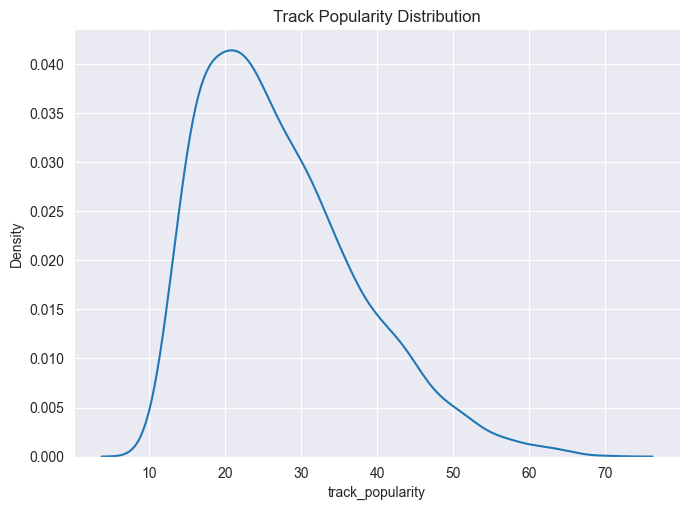

In [23]:
sns.displot(data=final_data['track_popularity'],  kind='kde',
            palette='cool', height=5, aspect=1.4).set(title='Track Popularity Distribution')

Describe track_popularity

In [25]:
final_data['track_popularity'].describe()

count    3000.000000
mean       27.315667
std        10.339680
min        10.000000
25%        19.000000
50%        25.000000
75%        33.000000
max        70.000000
Name: track_popularity, dtype: float64

Plot heatmap of the data correlation between attributes

<AxesSubplot:>

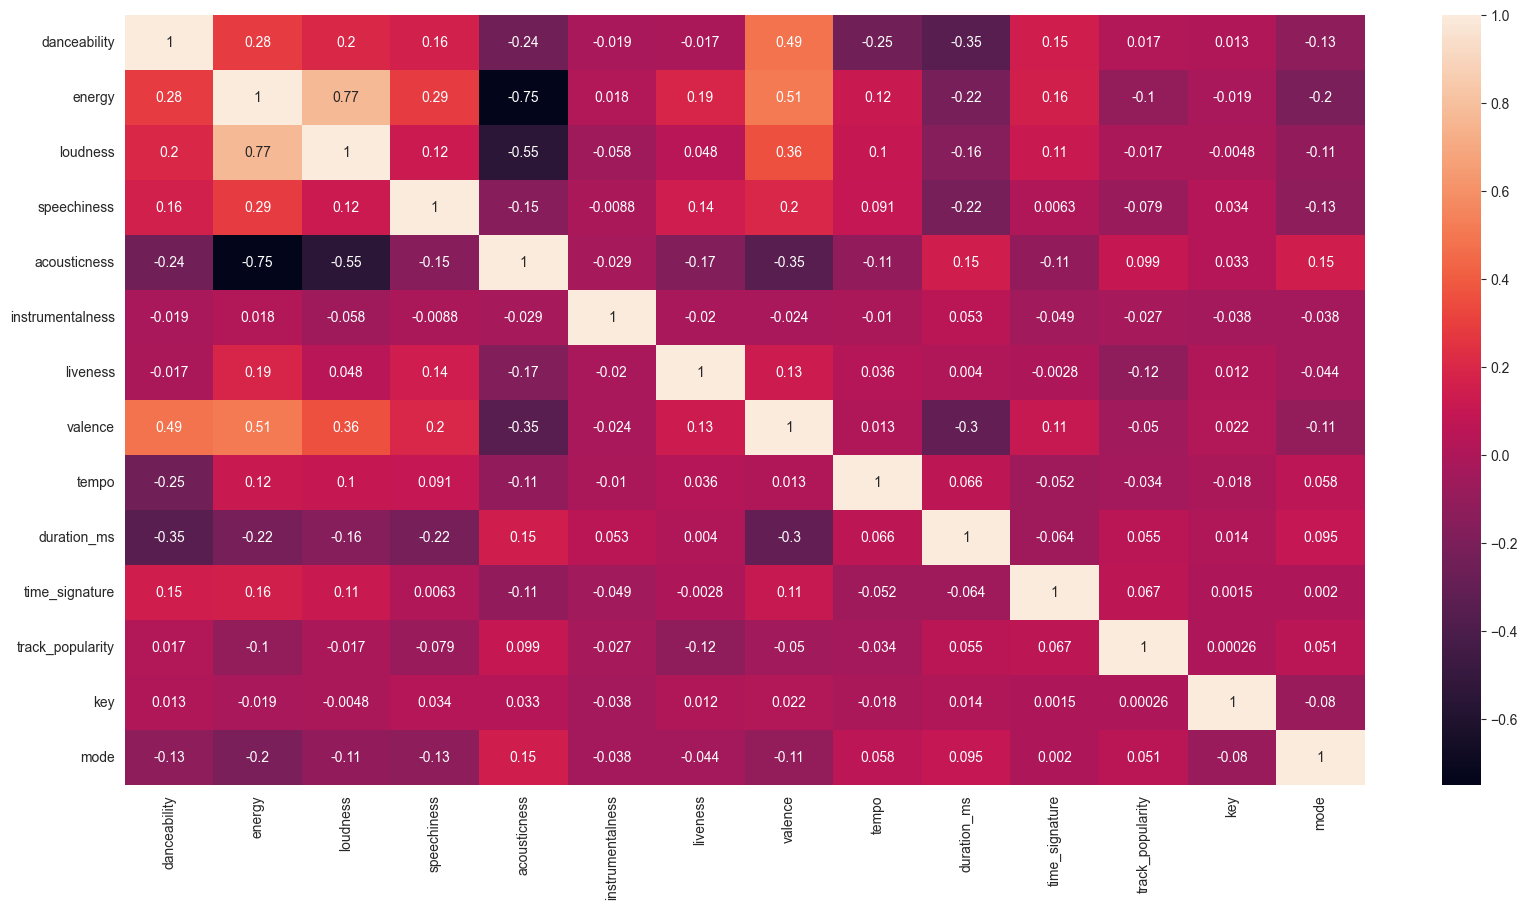

In [26]:
plt.figure(figsize=(20, 10))
sns.heatmap(final_data.corr(),annot = True)

Find attribues correlations

In [27]:
abs(final_data.corr()['track_popularity']).sort_values()

key                 0.000264
loudness            0.016686
danceability        0.017422
instrumentalness    0.027312
tempo               0.033792
valence             0.049611
mode                0.051340
duration_ms         0.054614
time_signature      0.067012
speechiness         0.078855
acousticness        0.098823
energy              0.103944
liveness            0.117523
track_popularity    1.000000
Name: track_popularity, dtype: float64

Drop attributes with absolute correlation value less than 0.05

In [28]:
spotify_data = final_data.drop(columns = ['instrumentalness', 'tempo', 'key', 'valence',"loudness","danceability"])

In [29]:
spotify_data.head()

,energy,speechiness,acousticness,liveness,duration_ms,time_signature,track_popularity,mode
0,0.729314,0.686570,0.495070,-0.548856,-1.324913,0.223086,62,1
1,0.812747,-0.379698,-1.322106,1.150022,0.118726,0.223086,53,1
2,-0.168818,-0.366487,0.912512,-0.184320,1.664406,0.223086,56,1
3,-1.621534,-0.349502,1.682170,-0.541978,-1.081130,0.223086,46,1
4,-1.091489,-0.217398,1.183197,0.022022,-0.315335,0.223086,49,1


## Step 3: Data Modeling
### Split Dataset

Split data into training and testing datasets

In [31]:
y = spotify_data['track_popularity']
x_final_data = spotify_data.drop(columns=['track_popularity'])
x = x_final_data

X_train, X_test, y_train, y_test = train_test_split(x, y,
    test_size=0.2, shuffle = True, random_state = 100)
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

### Training

I selected few models to train the datasets

In [48]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['ARDRegression', 
                      'BayesianRidge', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'AdaBoostRegressor', 'HistGradientBoostingRegressor', 'MLPRegressor', 'Baseline']
    # X_train = X_train.drop(columns='Grade')
    # X_test = X_test.drop(columns='Grade')
    
    # Instantiate the models
    model1 = ARDRegression(compute_score=True, n_iter=50)
    model2 = BayesianRidge(compute_score=True, n_iter=50)
    model3 = ExtraTreesRegressor(n_estimators=50)
    model4 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model5 = GradientBoostingRegressor(n_estimators=20)
    model6 = AdaBoostRegressor(random_state=0, n_estimators=50)
    model7 = HistGradientBoostingRegressor()
    model8 = MLPRegressor(random_state=1, max_iter=100)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse', 'r_square'], index = model_name_list)

    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6, model7, model8]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        Adj_R_square = 1 - (1-r2_score(y_test, predictions)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse, Adj_R_square]
        
        #plot prediction
        plt.plot(predictions[:100])
        plt.plot(y_test.reset_index(drop=True)[:100])
        plt.figure(figsize=(400, 150))
        plt.show()
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    baseline_R_square = Adj_R_square
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse, baseline_R_square]
    
    return results

Evaluate data

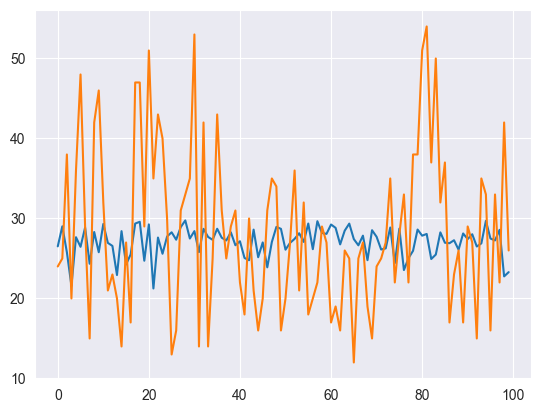

<Figure size 40000x15000 with 0 Axes>

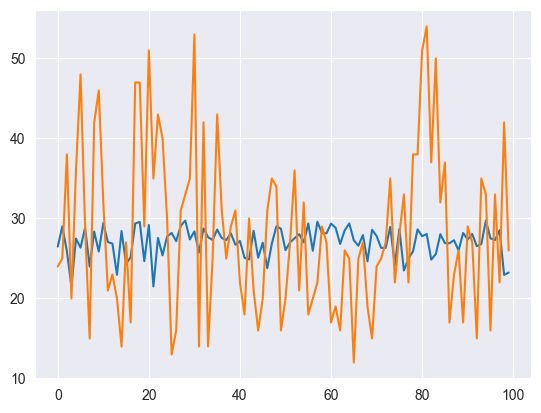

<Figure size 40000x15000 with 0 Axes>

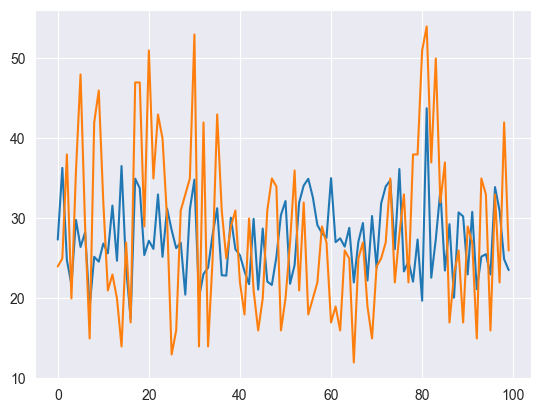

<Figure size 40000x15000 with 0 Axes>

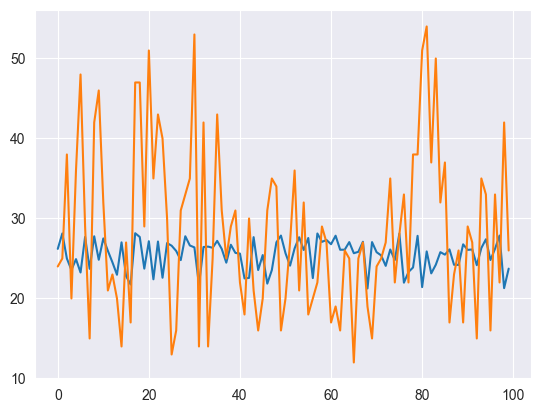

<Figure size 40000x15000 with 0 Axes>

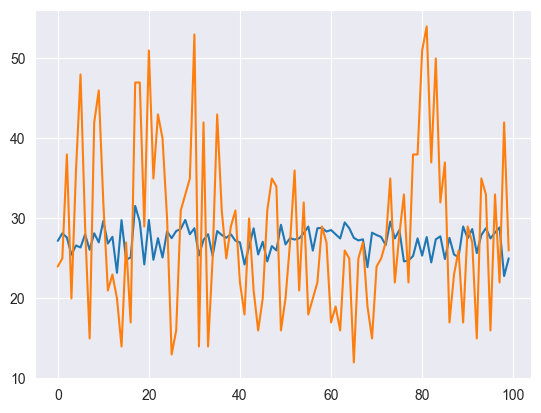

<Figure size 40000x15000 with 0 Axes>

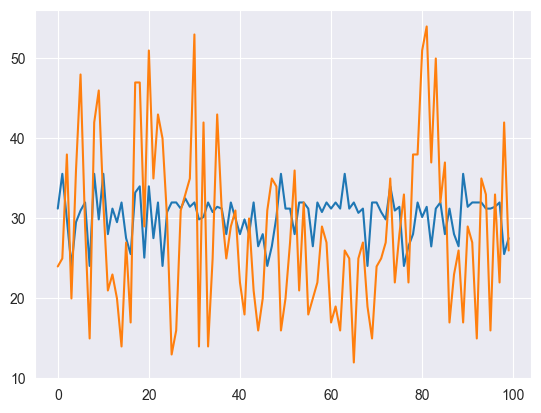

<Figure size 40000x15000 with 0 Axes>

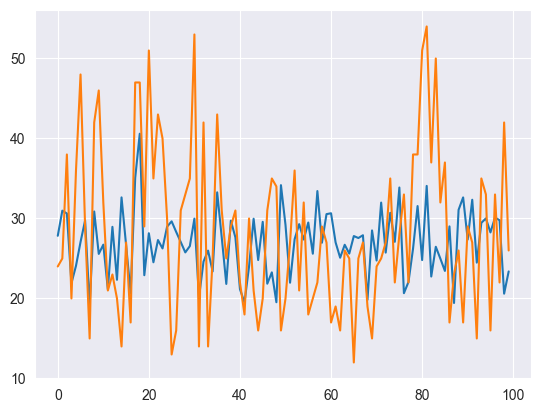

<Figure size 40000x15000 with 0 Axes>

C:\Users\Ryan Lu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


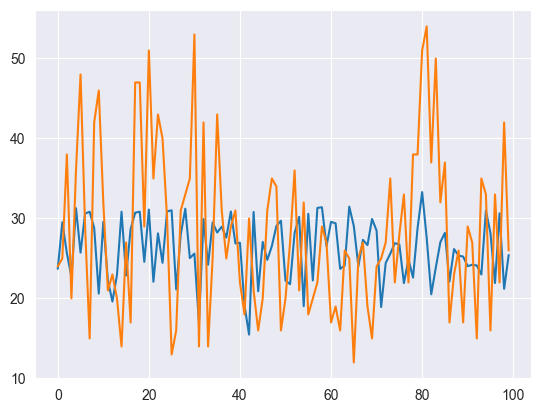

<Figure size 40000x15000 with 0 Axes>

In [49]:
results = evaluate(X_train, X_test, y_train, y_test)

In [50]:
print(results)

                                    mae       rmse  r_square
ARDRegression                  8.244852  10.198576  0.005692
BayesianRidge                  8.236433  10.193872  0.006609
Extra Trees                    8.755422  10.727309 -0.100078
SVM                            8.223381  10.458883 -0.045713
Gradient Boosted               8.219923  10.175777  0.010132
AdaBoostRegressor              8.796014  10.538669 -0.061729
HistGradientBoostingRegressor  8.292026  10.430672  -0.04008
MLPRegressor                   8.717404  10.869082 -0.129348
Baseline                           8.26  10.589775 -0.129348
